In [64]:
import pandas as pd
import numpy as np
import itertools

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import multiprocessing as mp
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pmdarima as pm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (12,5), "figure.dpi":100, 'xtick.labelsize':10, 'ytick.labelsize':10, 'axes.titlesize':12})

import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [4]:
df = pd.read_csv(f"./serie/04_tablon.txt", sep=";", decimal=".")
df["población"] = df["población"].astype(float)
df["semanaSanta"] = df["semanaSanta"].astype(int)
# df["pasajeros"] = df["pasajeros"].astype("int")

In [5]:
pc_train = 0.8
qt_train = int(len(df.pasajeros.dropna())*pc_train)
train = df[:qt_train]
test = df[qt_train:]

# Data Understanding

## Passengers

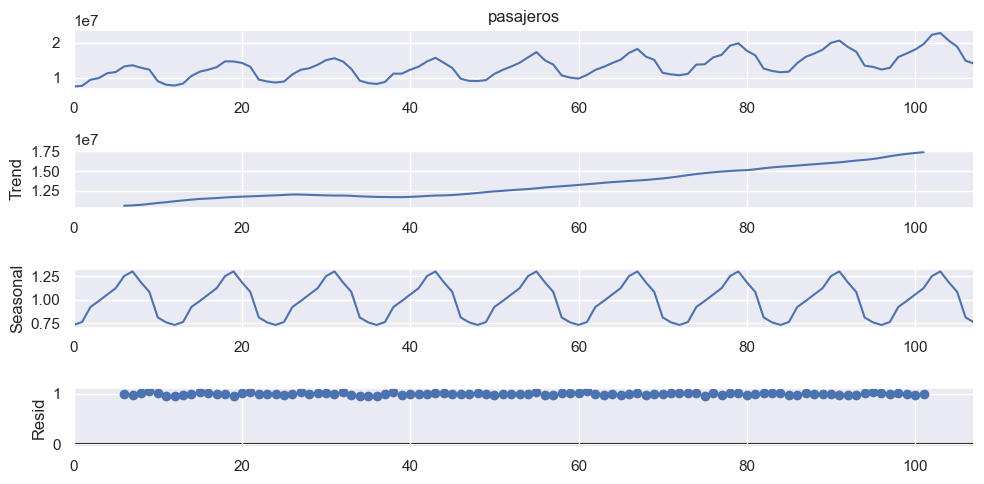

In [6]:

pasajeros = df["pasajeros"].to_numpy()
fig = seasonal_decompose(df.pasajeros.dropna(), period=12, model="mul").plot()
fig.set_size_inches((10,5))
fig.tight_layout()
plt.show()


- Se puede observar que la serie presenta una tendencia a la alza.
- La serie presenta una estacionalidad de frecuencia 12.

## Complete Dataset

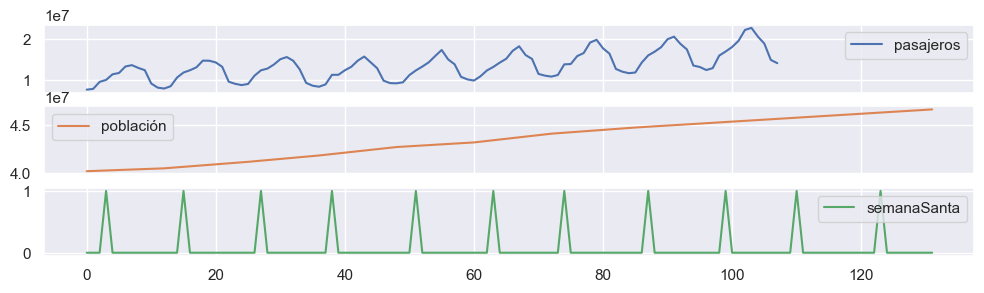

In [7]:

fig, ax = plt.subplots(3, 1, figsize=(12,3), sharex=True)
df.plot(ax=ax, subplots=True)
plt.show()

- Visualización de las variables pasajeros, población y semanaSanta. Se deduce que la población puede estar directamente relacionada con la tendencia alcista de pasajeros y semanaSanta aplica la componente estacional.

# ARIMA

In [8]:
pasajeros = df.pasajeros
pasajeros_dif = df.pasajeros.diff()
pasajeros_difdif = df.pasajeros.diff().diff()
pasajeros_log = np.log10(df.pasajeros)
pasajeros_log_dif = np.log10(df.pasajeros).diff()
pasajeros_log_difdif = np.log10(df.pasajeros).diff().diff()


## Parameters p, d and q

### Finding d: Differencing Order. Non Stationary Hipothesis

In [9]:
result = adfuller(df.pasajeros.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.124699029933589
p-value: 0.9954220028521101


- No podemos rechazar la hipótesis no estacionaria. (p-value>0.05)

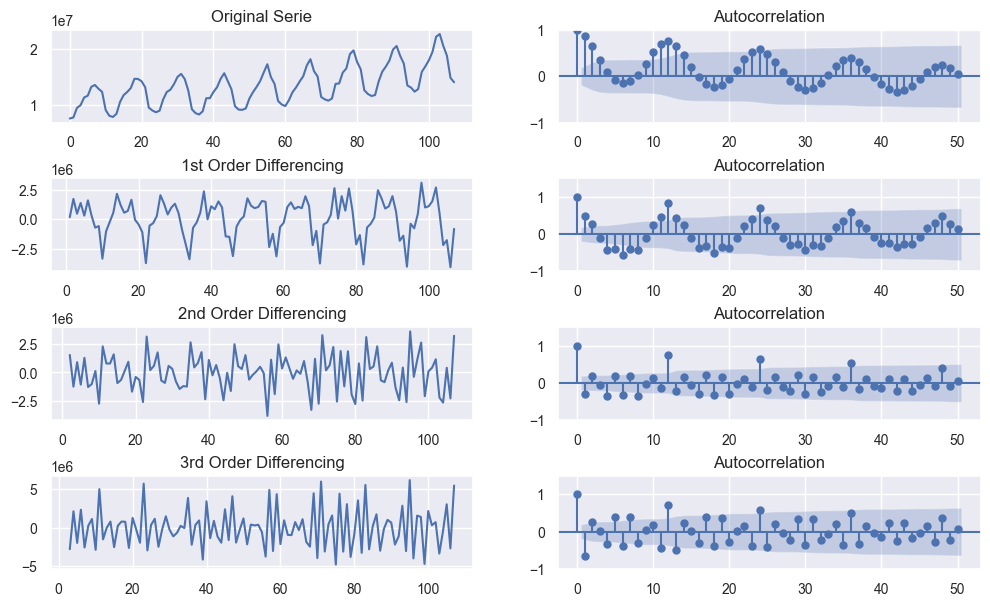

In [471]:
plt.rcParams.update({"figure.figsize": (12,7), "figure.dpi":100, 'xtick.labelsize':10, 'ytick.labelsize':10, 'axes.titlesize':12})
# Original Series
fig, ax = plt.subplots(4,2, sharex=False)
ax[0,0].plot(df.pasajeros)
ax[0,0].set_title("Original Serie")
# plot_pacf(pasajeros, ax=ax[0,0], lags=50)
plot_acf(pasajeros.dropna(), ax=ax[0,1], lags=50)

#1st order differencing
ax[1,0].plot(df.pasajeros.diff())
ax[1,0].set_title("1st Order Differencing")
# plot_pacf(pasajeros_dif.dropna(), ax=ax[1,0], lags=50)
plot_acf(pasajeros_dif.dropna(), ax=ax[1,1], lags=50)

#2nd order differencing
ax[2,0].plot(df.pasajeros.diff().diff())
ax[2,0].set_title("2nd Order Differencing")
# plot_pacf(pasajeros_difdif.dropna(), ax=ax[2,0], lags=50)
plot_acf(pasajeros_difdif.dropna(), ax=ax[2,1], lags=50)

#3rd order differencing
ax[3,0].plot(df.pasajeros.diff().diff().diff())
ax[3,0].set_title("3rd Order Differencing")
# plot_pacf(pasajeros_difdif.dropna(), ax=ax[2,0], lags=50)
plot_acf(df.pasajeros.diff().diff().diff().dropna(), ax=ax[3,1], lags=50)

ax[1,1].set_ylim(-1,1.5)
ax[2,1].set_ylim(-1,1.5)
ax[3,1].set_ylim(-1,1.5)

plt.subplots_adjust(hspace=0.6)
plt.show()

In [11]:
print("ADF STATISTICS:\n")


result = adfuller(df.pasajeros.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(key, value)

print("\n***********************************************")

print("ADF Statistic for 1st Order Differencing")
result = adfuller(df.pasajeros.diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(key, value)

print("\n***********************************************")

print("ADF Statistic for 1st Order Differencing")
result = adfuller(df.pasajeros.diff().diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(key, value)



ADF STATISTICS:

ADF Statistic: 1.124699029933589
p-value: 0.9954220028521101
Critical Values:
1% -3.5019123847798657
5% -2.892815255482889
10% -2.583453861475781

***********************************************
ADF Statistic for 1st Order Differencing
ADF Statistic: -2.213532347863381
p-value: 0.20137070688709446
Critical Values:
1% -3.5019123847798657
5% -2.892815255482889
10% -2.583453861475781

***********************************************
ADF Statistic for 1st Order Differencing
ADF Statistic: -7.450686252128655
p-value: 5.681290153904488e-11
Critical Values:
1% -3.503514579651927
5% -2.893507960466837
10% -2.583823615311909


- Podemos determinar que la serie alcanza la estacionalidad tras dos ordenes de diferenciación.
- ADF se vuelve negativo muy rápido por lo que podemos pensar que con 2 ordenes de diferenciación la serie esté sobrediferenciada.
- Debemos escoger entre d=1 o d=2.
- Escogemos en un inicio d=2.

### Diferenciación estacional y estacionaria

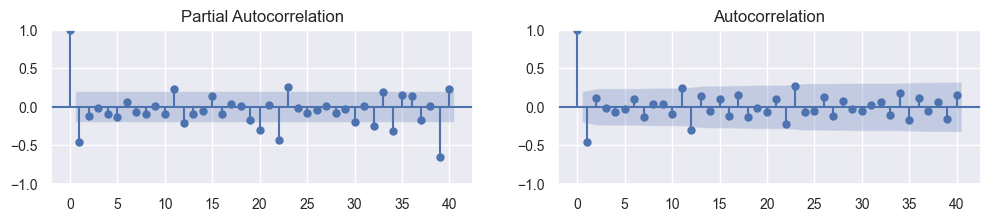

In [474]:
pasajeros_diff12 = df.pasajeros.diff(12)[12:]
pasajeros_diff12_1 = pasajeros_diff12.diff()[1:]

plt.rcParams.update({"figure.figsize": (12,2), "figure.dpi":100, 'xtick.labelsize':10, 'ytick.labelsize':10, 'axes.titlesize':12})
# Original Series
fig, ax = plt.subplots(1,2, sharex=False)
# plot_pacf(pasajeros_diff12.dropna(), ax=ax[0,0], lags=40)
# plot_acf(pasajeros_diff12.dropna(), ax=ax[0,1], lags=40)

#1st order differencing
plot_pacf(pasajeros_diff12_1.dropna(), ax=ax[0], lags=40)
plot_acf(pasajeros_diff12_1.dropna(), ax=ax[1], lags=40)

plt.show()


## Models Configurations

### ARIMA(1,1,0)(0,1,0)[12]

In [475]:
model = ARIMA(train.pasajeros, order=(1,1,1), seasonal_order=(0,1,0,12))
model_fit2 = model.fit()
print(model_fit2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         pasajeros   No. Observations:                   80
Model:             ARIMA(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -971.617
Date:                           Tue, 28 Feb 2023   AIC                           1949.234
Time:                                   17:36:08   BIC                           1955.848
Sample:                                        0   HQIC                          1951.851
                                            - 80                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1306      0.323      0.404      0.686      -0.503       0.764
ma.L1         -0.2695      0.309     -0.872

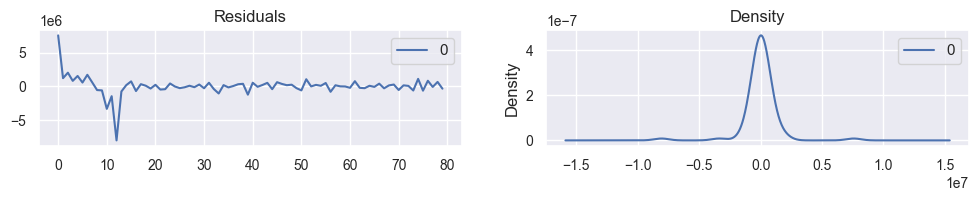

In [476]:
residuals = pd.DataFrame(model_fit2.resid)
fig, ax = plt.subplots(1,2, figsize=(12, 1.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

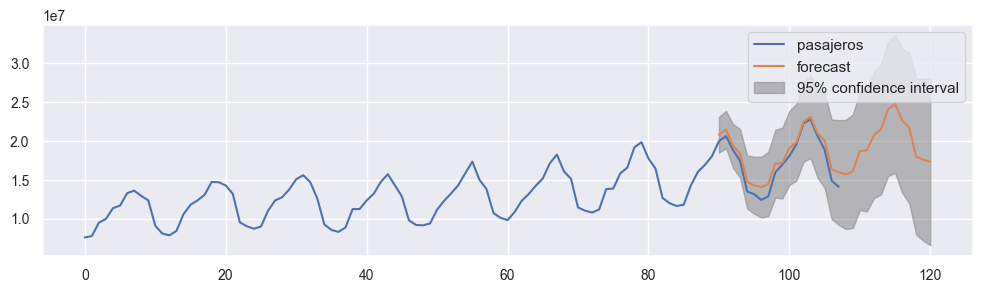

In [477]:
plt.rcParams.update({"figure.figsize": (12,3), "figure.dpi":100, 'xtick.labelsize':10, 'ytick.labelsize':10, 'axes.titlesize':12})
fig, ax = plt.subplots()
ax = df.pasajeros.plot(ax=ax)
plot_predict(model_fit2, 90, 120, dynamic=True, plot_insample=False, ax=ax)
plt.show()

## Optimización Hiperparámetros

In [293]:
X_train = train.pasajeros
X_test = test.pasajeros
model = pm.auto_arima(X_train, seasonal=True, m=12, trace=True)
preds = model.predict(50)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1954.219, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1950.612, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1947.854, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1948.680, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1945.914, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1947.849, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1949.912, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1948.187, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1949.234, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1946.780, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1951.334, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=1948.100, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.590 seconds


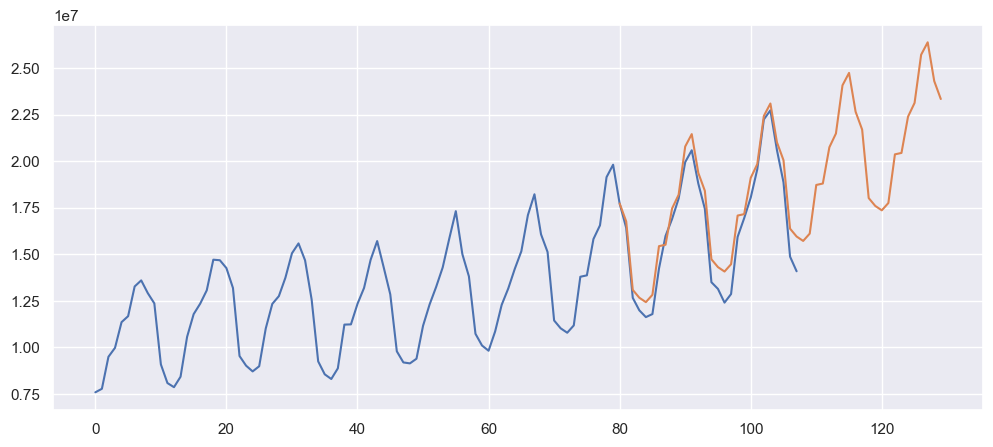

In [294]:
fig, ax = plt.subplots()
df.pasajeros.plot(ax=ax)
plt.plot(preds)
plt.show()

# Linear Regresion

In [225]:
window = 12
df_lr = pd.DataFrame()
df_lr["pasajeros"] = df[["pasajeros"]].dropna()
df_lr["predict"] = df[["pasajeros"]].shift(-window)


## Data Prep

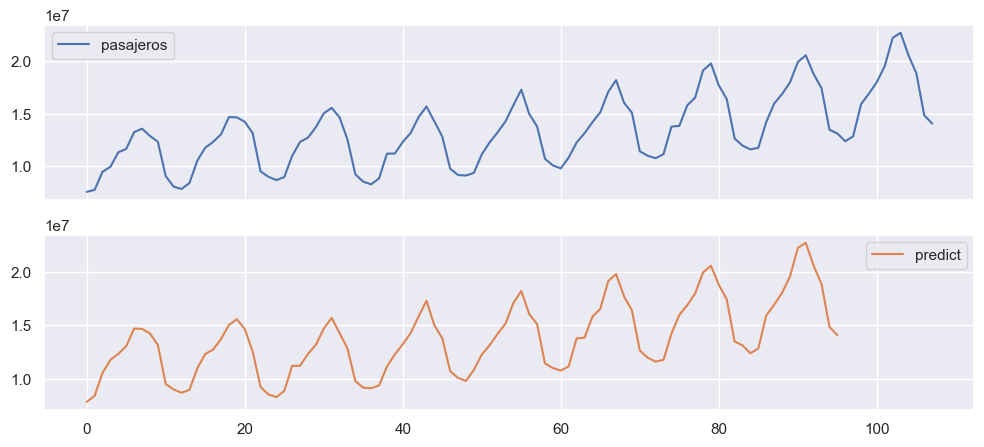

In [226]:
df_lr.plot(subplots=True)
plt.show()

In [227]:
X = np.array(df_lr[["pasajeros"]])[:-window]
y = np.array(df_lr[["predict"]])[:-window]
len_train = int(0.75*len(X))
x_train, y_train = X[:len_train], y[:len_train]
x_test, y_test = X[len_train:], y[len_train:]

In [228]:
lr = LinearRegression()
lr_fit = lr.fit(x_train, y_train)

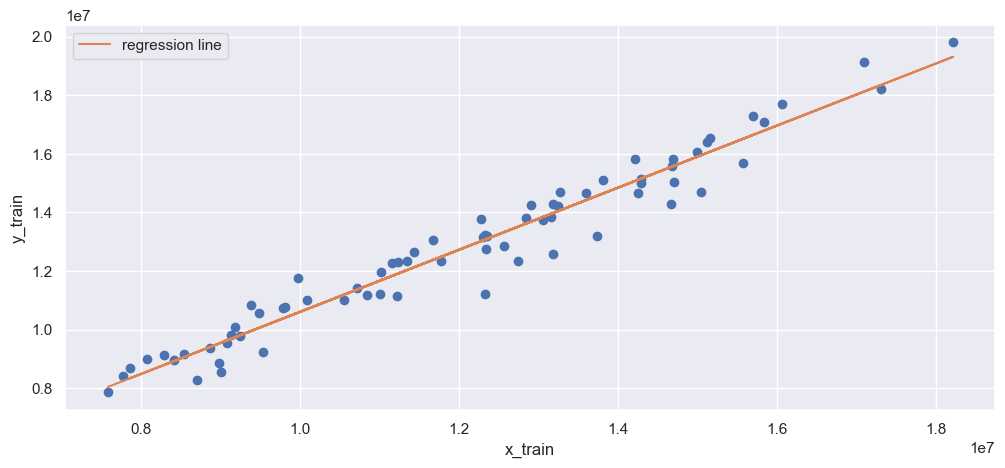

In [229]:
plt.plot(x_train, y_train, "o")
plt.xlabel("x_train")
plt.ylabel("y_train")
plt.plot(x_train.flatten(), lr_fit.predict(x_train), label="regression line")
plt.legend()

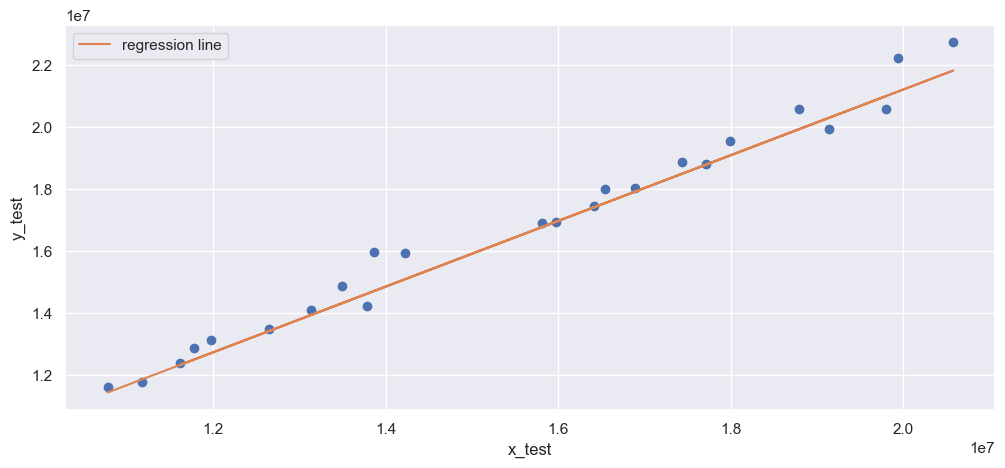

In [230]:
plt.plot(x_test, y_test, "o")
plt.xlabel("x_test")
plt.ylabel("y_test")
plt.plot(x_test.flatten(), lr_fit.predict(x_test), label="regression line")
plt.legend()

## Predicción

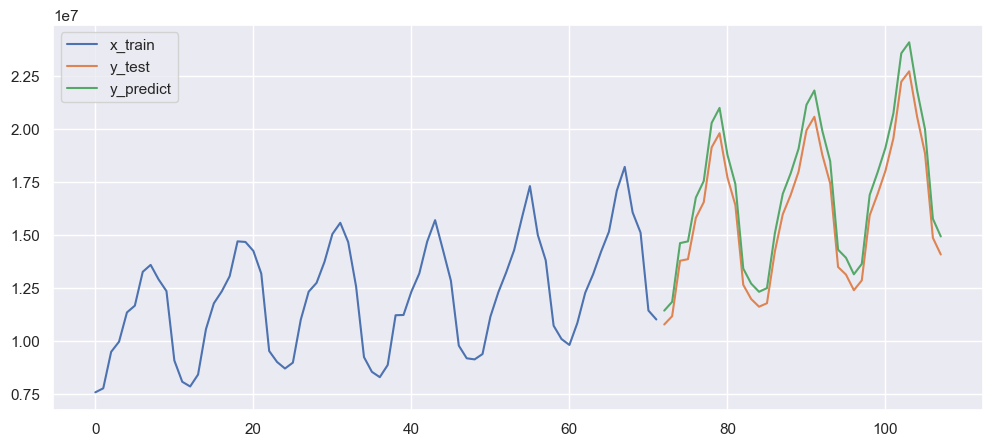

In [283]:
plt.figure()
df_lr.pasajeros[:len_train].plot(label="x_train")
df_lr.pasajeros[len_train:].plot(label="y_test")

shape_pred = df_lr.pasajeros[len_train:].shape
qt_pred = shape_pred[0]
pd.Series(lr.predict(df_lr.pasajeros[-qt_pred:].values.reshape(-1,1)).reshape(shape_pred),
           index = df_lr.pasajeros[len_train:].index).plot(label="y_predict")
plt.legend(loc=2)